# 0. Preliminaries

   ## Imports

In [203]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import HTML as html_print
import seaborn as sns    # for heatmaps

import logomaker         # if not present install with: pip install logomaker

## Parameters of the problem

In [220]:
# These are global variables to be used throughout the notebook
num_sequences = 50
sequence_length = 100
motif_length = 8
alpha = 1 # this alpha is used when estimating the motif

## Initialize the random number generator

In [205]:
random_seed = 2023
rng = np.random.default_rng(random_seed)

# 1. Generate the data

## Data generating functions

In [206]:
def sample_motif(motif_length=motif_length, alpha=0.1):
    """
    Sample a motif from the dirichlet distribution
    """
    return rng.dirichlet([alpha]*4, motif_length) # fill using rng.dirichlet() 

        
def sample_sequence_from_motif(motif):
    """
    Sample an instance of the motif from the distribution defined by the motif
    """
    # Initialize the sequence array
    motif_sequence = np.zeros(motif_length, dtype=int)

    # Draw each sequence element from motif
    for k in range(motif_length):
        motif_sequence[k] = rng.choice(4, size=1, p=motif[k, :]) # fill using rng.choice() 

    return motif_sequence
    
    
def generate_sequences(motif):
    """
    Sample a set of sequences, with a single instance of the motif 
    embedded at a random position in each sequence
    """        
    # Initialize the sequences matrix with random bases
    sequences = rng.integers(4, size=(num_sequences, sequence_length))

    # Draw positions for motifs
    positions = rng.integers(sequence_length - motif_length + 1, size=num_sequences)

    # Per full sequence, draw from motif and insert
    for n in range(num_sequences):
        sequences[n, positions[n]:positions[n]+motif_length] = sample_sequence_from_motif(motif) # replace the subsequence of length motif_length at positions[n] with a motif instance
            
    return sequences, positions

## Motif and sequence printing and drawing functions

In [207]:
def print_motif(motif):
    """
    Print the motif array nicely
    """
    with np.printoptions(precision=3, suppress=True):
        print(motif)
        

def draw_motif(motif, title="",ax=None):
    """
    Draw a logo of the motif with logomaker
    """
    # Make dataframe for logomake
    df = pd.DataFrame(motif, columns=["A", "C", "G", "T"])
    df = logomaker.transform_matrix(df, from_type="probability", to_type="information")
    logo = logomaker.Logo(df, ax=ax)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        logo.ax.set_title(title)
        logo.ax.set_xlabel("Position")
        logo.ax.set_ylabel("Total information")
        logo.ax.set_ylim(0, np.log2(4))
        logo.fig.show()

        
def cstr(s, color='black'):
    return "<text style='color:{};font-family:monospace;font-size:1em'>{}</text>".format(color, s)

def draw_sequences(sequences, positions=None):
    """
    Show the sequences in nice text, optionally highlighting the motif positions in red
    """
    text = ""
    for n in range(len(sequences)):
        row = ""
        for s in sequences[n]:
            row += "ACGT"[s]
        row += "\n"
        
        # If no positions to show, everything is black
        if positions is None:                  
            row = cstr(row, color='black')
    
        # Otherwise, color in red
        else:
            pos = positions[n]
            row = \
                cstr(row[:pos], color="black") + \
                cstr(row[pos:pos+motif_length], color="red") + \
                cstr(row[pos+motif_length:], color="black")
        
        text += row
    
    display(html_print(text))


## An example of data generation
Get the next two cells to run yourself, by fixing the code in the data generating functions above, then explore what happens as you vary alpha, e.g. to 0.5, 1, 5, perhaps 0.01.  Try each value several times.

[[0.028 0.906 0.067 0.   ]
 [0.    0.    0.354 0.645]
 [0.068 0.    0.932 0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.266 0.    0.734]
 [0.    0.    0.078 0.922]
 [0.988 0.    0.    0.012]
 [0.867 0.13  0.001 0.002]]


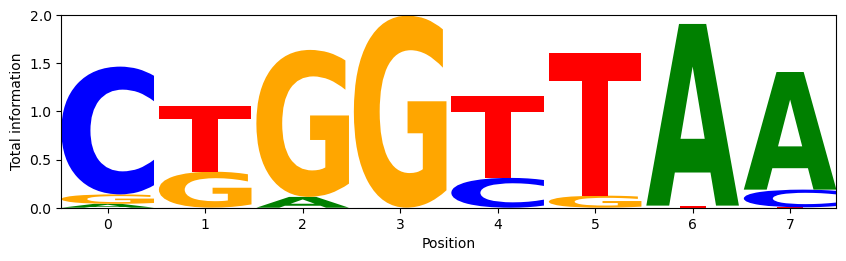

In [209]:
M = sample_motif(alpha = 0.1)
print_motif(M)
draw_motif(M)

In [221]:
sequences, positions = generate_sequences(M)
draw_sequences(sequences[:20], positions)  # use without positions to show without highlighting

# 2. Expectation-Maximization

## Calculate log-likelihood of data

In [211]:
def log_likelihood(sequences, motif):
    """
    Calculate the log-likehood of the sequences given the motif, 
    integrating over all positions.
    """
    # Initialize
    ll = 0.0
    max_position = sequence_length - motif_length + 1
    constant_part = (1.0 / max_position) * (1.0/4)**(sequence_length - motif_length)
    
    # Per sequence, add the log-likelihood
    for n in range(num_sequences):
        pseq = 0.0
        for i in range(max_position):
            # add to pseq the probability of sequence n with motif at position i (several lines needed)
            part = constant_part
            for k in range(motif_length):
                part *= motif[k, sequences[n, i + k]] 
            pseq += part
        ll += np.log(pseq)
                        
    return ll
        

## Expectation step

In [212]:
def expectation_step(sequences, motif):
    """
    Calculate the posterior probabilities of the motif being at each position in each sequence
    """
    # Initialize
    max_position = sequence_length - motif_length + 1
    positions_posterior = np.zeros((num_sequences, max_position), dtype=float)
    
    # Per sequence, calculate the posterior
    for n in range(num_sequences):
        # Calculate the likelihood of each k-mer in the sequence 
        for i in range(max_position):
            likelihood = 1.0
            for k in range(motif_length):
                likelihood *= motif[k, sequences[n, i + k]] # update the joint likelihood for position k in the motif
            positions_posterior[n, i] = likelihood
            
        # Normalize the posteriors for sequence n to sum to 1
        positions_posterior[n, :] /= positions_posterior[n, :].sum()
        
    return positions_posterior
    

## Maximization step

In [213]:
def maximization_step(sequences, positions_posterior):
    """
    Re-estimate the motif by summing expected counts using the posterior from the expectation_step
    """
    # Initialize
    max_position = sequence_length - motif_length + 1
    motif_estimate = np.zeros((motif_length, 4), dtype=float)   
    
    # Add dirichlet prior
    motif_estimate += alpha
    
    # Build the estimate
    for k in range(motif_length):
        for n in range(num_sequences):
            for i in range(max_position):
                # Which nucleotide is in the k-th position of the i-th k-mer 
                # in the n-th sequence?
                j = sequences[n, i+k]
                
                # Update the respective estimate
                motif_estimate[k, j] += positions_posterior[n, i]
                
        motif_estimate[k, :] /= motif_estimate[k, :].sum() # Normalize the motif_estimates at k to sum to 1
        
    return motif_estimate
        
    

## EM algorithm

In [214]:
def expectation_maximization(sequences, n_iterations, print_every=None):
    """
    search for a maximum likelihood motif estimate by alternating expectation_ and maximisation_ steps
    return the estimated motif, and the log likelihoods, position distributions and motifs at each step
    """
    # Initialize the motif estimate randomly
    est_motif = rng.random(size=(motif_length, 4))
    est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Iterate E and M steps
    lls = []
    positions_posteriors = []
    motifs = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        ll = log_likelihood(sequences, est_motif)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
        
        # E step
        positions_posterior = expectation_step(sequences, est_motif)
        positions_posteriors.append(positions_posterior)
        
        # M step
        est_motif = maximization_step(sequences, positions_posterior)
        motifs.append(est_motif)
    
    return est_motif, lls, positions_posteriors, motifs

## Plot results

In [235]:
def plot_results(iters,est_motif,lls,posteriors,motifs):
    print (f"LL with true motif {log_likelihood(sequences,M)}")
    print (f"LL with final estimated motif {log_likelihood(sequences,est_motif)}")
    
    # plot the true and final estimated motifs
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    draw_motif(M,ax=axs[0])
    axs[0].set_title("True motif")
    draw_motif(est_motif,ax=axs[1])
    axs[1].set_title("Final estimated motif")
   
    if lls is not None:
        # plot the log likelihoods
        plt.figure()
        plt.plot(lls)
        plt.xlabel("# of iteration")
        plt.ylabel("log likelihood")
    
    if len(iters) > 0 and posteriors is not None:
        # plot heatmaps of the motif locations at given iterations
        fig, axs = plt.subplots(1, len(iters), figsize=(20, 8))
        for ax, n_iter in zip(axs, iters):
            sns.heatmap(posteriors[n_iter][:,:], ax=ax, vmin=0, vmax=1);
            ax.set_title(f"Iteration # {n_iter}")
            ax.set_ylabel("Sequence #")
            ax.set_xlabel("Position")
    
    if len(iters) > 0 and motifs is not None:
       # and below them the motifs
        fig, axs = plt.subplots(1, len(iters), figsize=(20, 2))
        for ax, n_iter in zip(axs, iters):
            draw_motif(motifs[n_iter],ax=ax)

## Run it!

In [216]:
est_motif, lls, positions_posteriors, motifs = expectation_maximization(sequences, 100, print_every=10)

Iteration 0: LL = -13855.846053607997
Iteration 10: LL = -13603.788237121626
Iteration 20: LL = -13603.775742584448
Iteration 30: LL = -13603.775740332316
Iteration 40: LL = -13603.77574033177
Iteration 50: LL = -13603.77574033177
Iteration 60: LL = -13603.77574033177
Iteration 70: LL = -13603.77574033177
Iteration 80: LL = -13603.77574033177
Iteration 90: LL = -13603.77574033177


LL with true motif -13470.318990309164
LL with final estimated motif -13603.77574033177


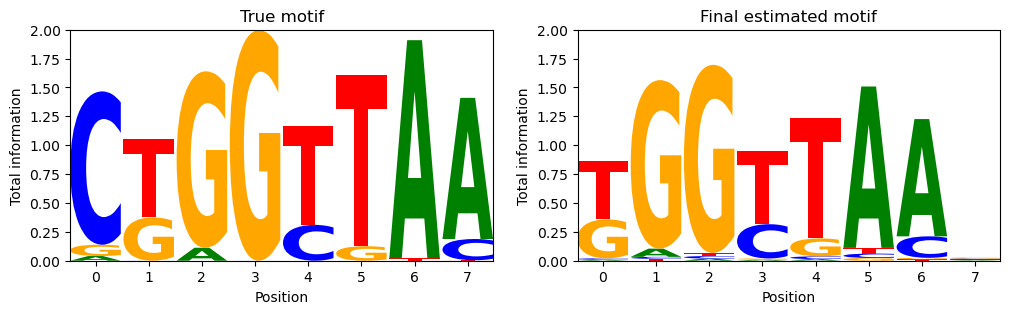

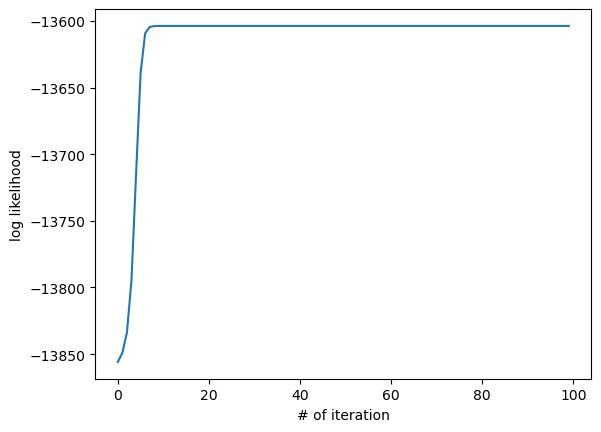

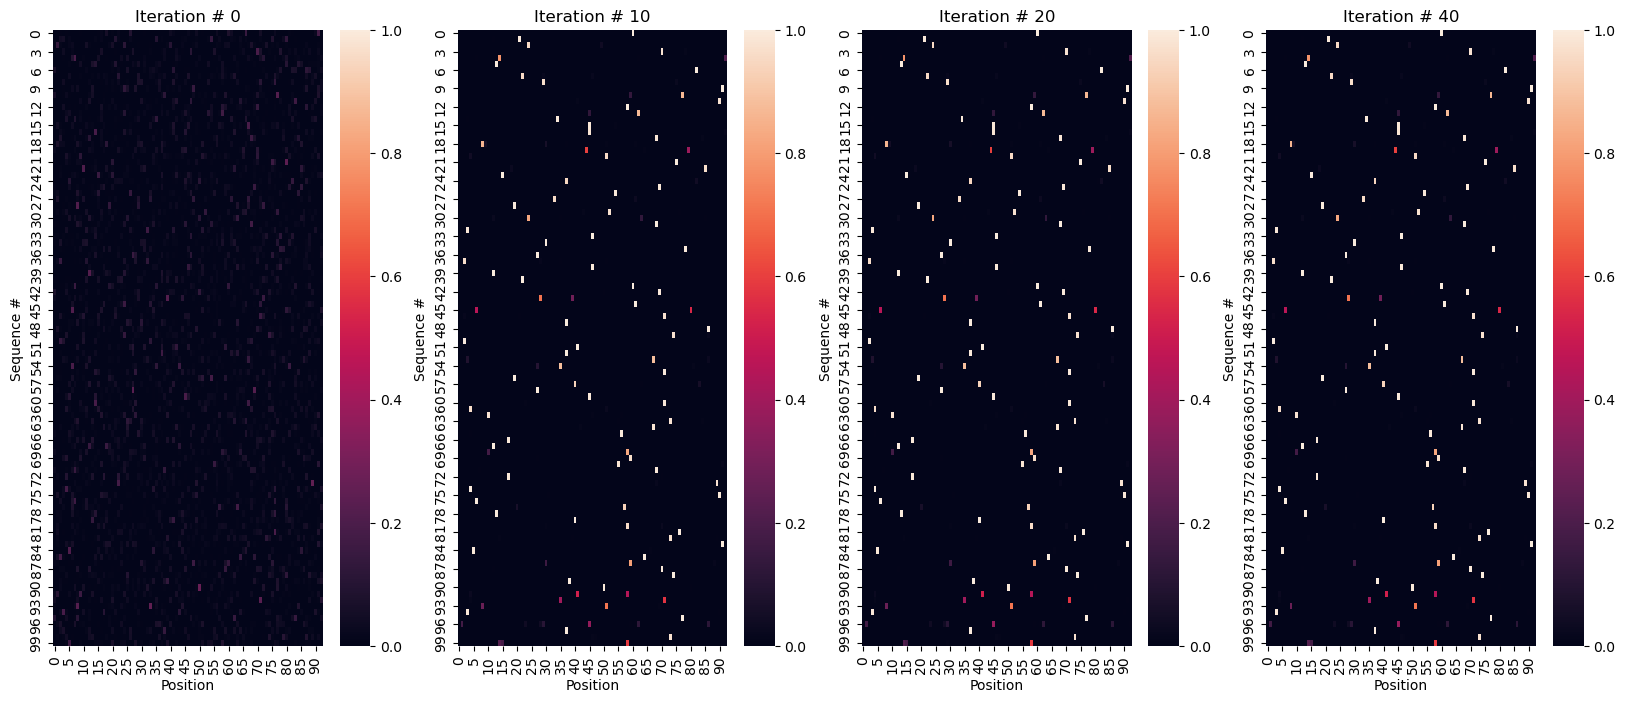

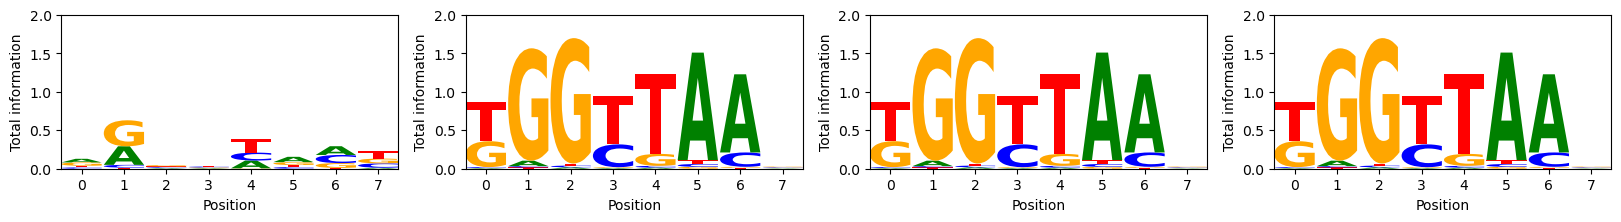

In [217]:
plot_results([0,10,20,40], est_motif, lls, positions_posteriors, motifs)

### Try running the following cell several times. In what ways does the output vary, and why?

Iteration 0: LL = -6934.024941729219
Iteration 10: LL = -6928.894627668793
Iteration 20: LL = -6826.984105450954
Iteration 30: LL = -6817.275989046757
Iteration 40: LL = -6817.275896296037
LL with true motif -6811.158200948753
LL with final estimated motif -6817.275896293208


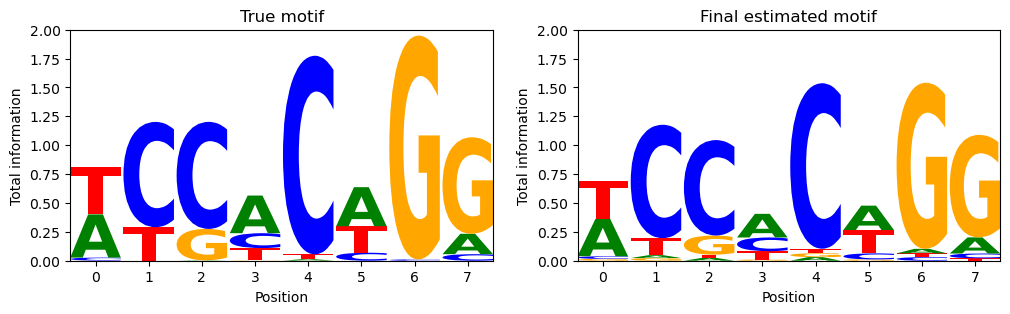

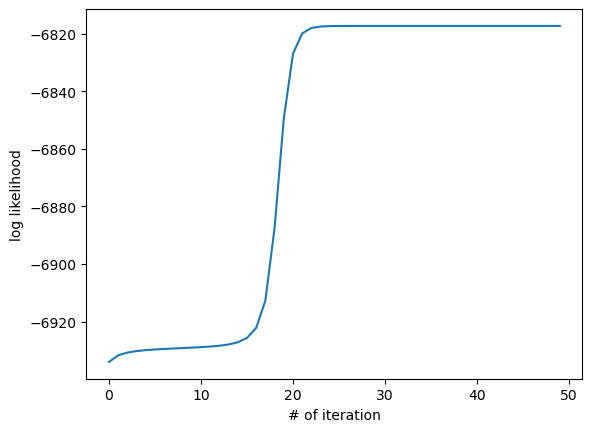

In [265]:
est_motif, lls, positions_posteriors, motifs = expectation_maximization(sequences, 50, print_every=10)
plot_results([], est_motif, lls, positions_posteriors, motifs)

### Now lets try making different motifs, with different prior Dirichlet alpha

Iteration 0: LL = -6931.105659393535
Iteration 10: LL = -6925.1043510326435
Iteration 20: LL = -6905.564115744259
Iteration 30: LL = -6904.291574128609
Iteration 40: LL = -6903.727794439112
LL with true motif -6811.158200948753
LL with final estimated motif -6900.621682100833


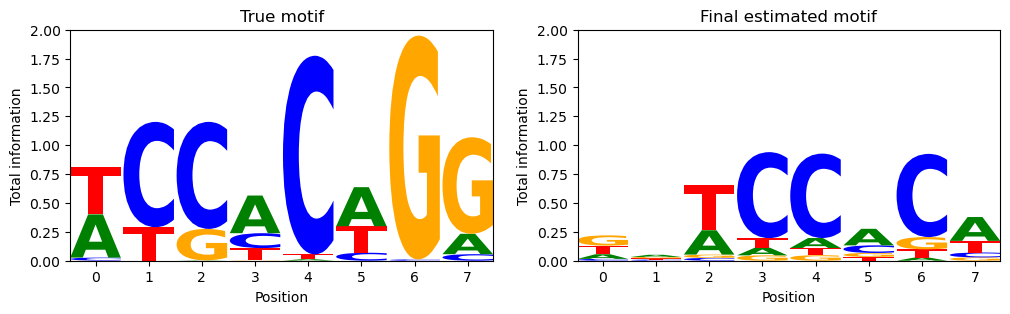

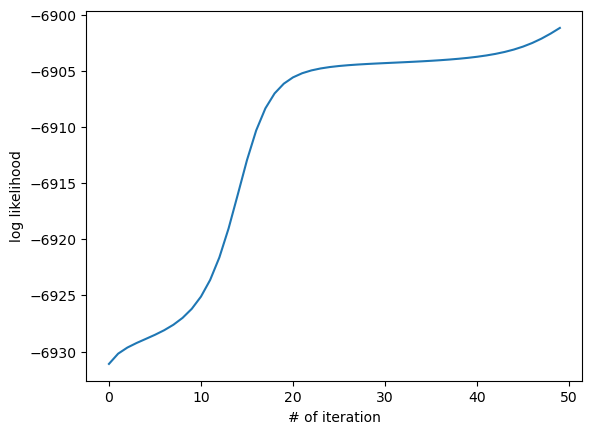

In [245]:
M = sample_motif(alpha = 0.1)       # try alpha = 0.2, 0.5, 1, perhaps even more or less
# if it doesn't converge correctly you could try generating more sequences by uncommenting/changing the next line
# num_sequences = 100
sequences, positions = generate_sequences(M)
est_motif, lls, positions_posteriors, motifs = expectation_maximization(sequences, 50, print_every=10)
plot_results([], est_motif, lls, positions_posteriors, motifs)

# 3. MCMC

In [227]:
def log_likelihood_with_positions(sequences, positions, motif):
    
    # Initialize
    ll = 0.0
    max_position = sequence_length - motif_length + 1
    
    # Per sequence, add the log-likelihood
    for n in range(num_sequences):
        p = 0.0
        i = positions[n]
        q = 1
        for k in range(motif_length):
            q *= motif[k, sequences[n, i + k]] 
        p += q
        ll += np.log(p)
                        
    return ll

In [228]:
def gibbs_sample_position(sequences, est_motif, rng):
    
    max_position = sequence_length - motif_length + 1

    # Draw new positions
    positions_posterior = expectation_step(sequences, est_motif)
    positions = np.zeros(len(sequences), dtype=int)
    for n in range(num_sequences):
        positions[n] = rng.choice(max_position, p=positions_posterior[n])
        
    return positions


In [229]:
def calculate_posterior_dirichlet_parameters(alpha, sequences, positions, motif_length):
    
    max_position = sequence_length - motif_length + 1
    
    # Calculate the posterior dirichlet parameters
    posterior_parameters = np.ones((motif_length, 4), dtype=float) * alpha    
    for k in range(motif_length):
        for n in range(num_sequences):
            a = sequences[n, positions[n] + k]
            posterior_parameters[k,a] += 1            
    
    return posterior_parameters
    

In [230]:
def gibbs_sample_motif(alpha, sequences, est_positions, motif_length, rng):
    
    max_position = sequence_length - motif_length + 1
    
    # Calculate the dirichlet parameters
    dirichlet_parameters = calculate_posterior_dirichlet_parameters(alpha, sequences, est_positions, motif_length)         
    
    # Draw new motif from this distribution
    est_motif = np.zeros((motif_length, 4), dtype=float)
    for k in range(motif_length):
        est_motif[k, :] = rng.dirichlet(dirichlet_parameters[k])
        
    return est_motif
    

In [231]:
def metropolis_hastings_step(sequences, est_positions, est_motif, current_ll, max_position, rng):
    
    # Make new state
    if rng.random() < 0.5:
        # abcdefgh -> habcdefg
        new_motif = np.roll(est_motif, 1, axis=0)
        new_positions = (est_positions - 1) % max_position
    else:
        # abcdefgh -> bcdefgha
        new_motif = np.roll(est_motif, -1, axis=0)
        new_positions = (est_positions + 1) % max_position
        
    # Calculate likelihood of new state
    new_ll = log_likelihood_with_positions(sequences, new_positions, new_motif)
    
    # Acceptance ratio
    acceptance_ratio = min(1.0, np.exp(new_ll - current_ll))
    
    # Accept if needed
    if rng.random() < acceptance_ratio:
        return new_motif, new_positions, True
    else:
        return est_motif, est_positions, False
        

In [238]:
def mcmc_sampling(sequences, motif_length, alpha, n_iterations, with_shifts=False, print_every=None):
    
    # Initialize the motif estimate randomly
    est_motif = rng.random(size=(motif_length, 4))
    est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Initialize positions
    max_position = sequence_length - motif_length + 1
    est_positions = rng.integers(max_position, size=num_sequences)
        
    # MCMC iterations
    lls = []
    states = []
    all_shifted = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        states.append([est_motif, est_positions])
        ll = log_likelihood_with_positions(sequences, est_positions, est_motif)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
            
        # Draw new positions
        est_positions = gibbs_sample_position(sequences, est_motif, rng)
        
        # Draw new motif
        est_motif = gibbs_sample_motif(alpha, sequences, est_positions, motif_length, rng)
        
        # Possible shift
        if with_shifts:
            est_motif, est_positions, shifted = metropolis_hastings_step(sequences, est_positions, est_motif,
                                                                         ll, max_position, rng)
            all_shifted.append(shifted)
        
    return est_motif, lls, states
    

## Run it several times, both with shifts off (default) and shifts on
How do these results compare with the EM solutions?

Look carefully at the log_likelihood values for the final solution. How are the final estimated motifs and their likelihoods different from those obtained by EM?

What happens when we allow shift operations using Metropolis-Hastings?

How does the number of iterations required compare with EM?
What might be sensible numbers for the burn-in period and for taking random samples from the Markov chain?
Maybe it would be interesting to try MCMC with a variety of motifs made with different values of alpha (remember to sample new sequences also when you make a new motif M).



Iteration 0: LL = -641.8174424050868
Iteration 50: LL = -229.5356292039879
Iteration 100: LL = -228.3280684385331
Iteration 150: LL = -238.5834180298936
Iteration 200: LL = -254.34275068200924
Iteration 250: LL = -246.39524402274475
Iteration 300: LL = -216.51300903591405
Iteration 350: LL = -222.78246098559302
Iteration 400: LL = -223.49906766477312
Iteration 450: LL = -217.91537860728207
LL with true motif -6811.158200948753
LL with final estimated motif -6817.288478105574


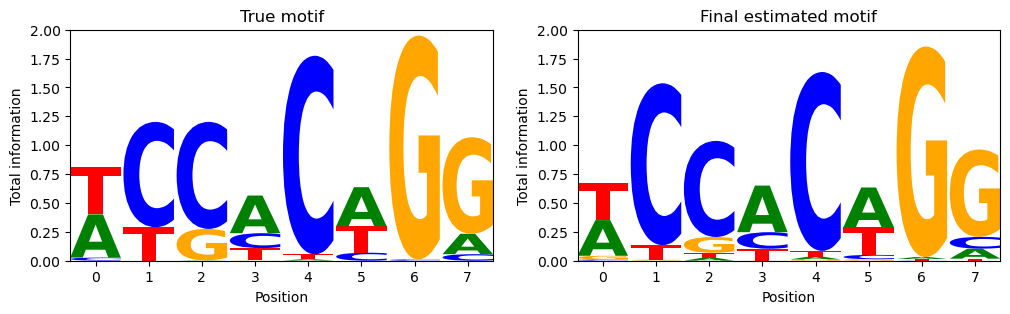

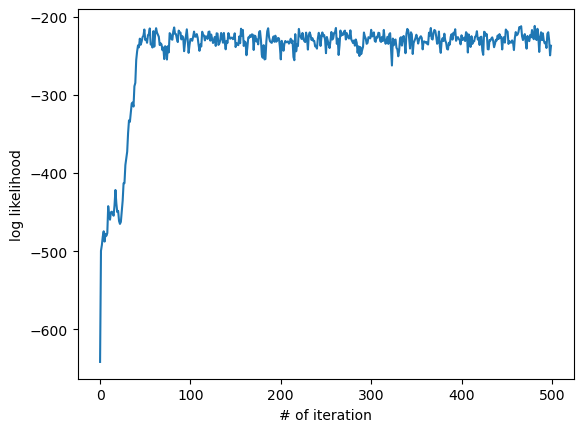

In [267]:
est_motif, lls, states = mcmc_sampling(sequences, motif_length, alpha, 500, with_shifts=False, print_every=50)
plot_results([],est_motif, lls, None, None)

# 4. Real data

In [190]:
from Bio import SeqIO

fasta_sequences = SeqIO.parse(open("muscle.fa"),'fasta')

sequences = rng.integers(4, size=(1000, 500)) # this is horrible hack
num_sequences = 0
for fasta in fasta_sequences:
    s = str(fasta.seq)
    table = s.maketrans('ACGT','0123')
    s = s.translate(table)
    sequence_length = len(s)
    for j in range(sequence_length):
        sequences[num_sequences, j] = s[j]
    num_sequences = num_sequences + 1

print (f"read {num_sequences} sequences of length {sequence_length}")

read 255 sequences of length 499


In [191]:
est_motif, lls, positions_posteriors, motifs = expectation_maximization(sequences, 100, print_every=10)

Iteration 0: LL = -176332.87680673992
Iteration 10: LL = -175711.3847821648
Iteration 20: LL = -175710.74453861118
Iteration 30: LL = -175710.5583492743
Iteration 40: LL = -175710.45478047602
Iteration 50: LL = -175710.39807878816
Iteration 60: LL = -175710.3674120652
Iteration 70: LL = -175710.35088220675
Iteration 80: LL = -175710.34198079302
Iteration 90: LL = -175710.3371889686


LL with true motif -176363.02958078223
LL with final estimated motif -175710.33460985552


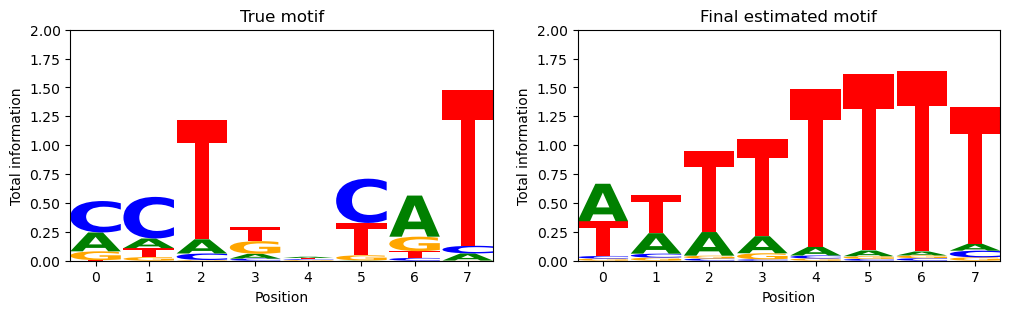

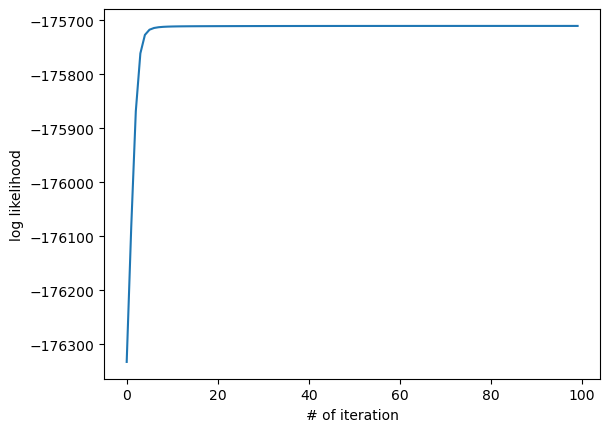

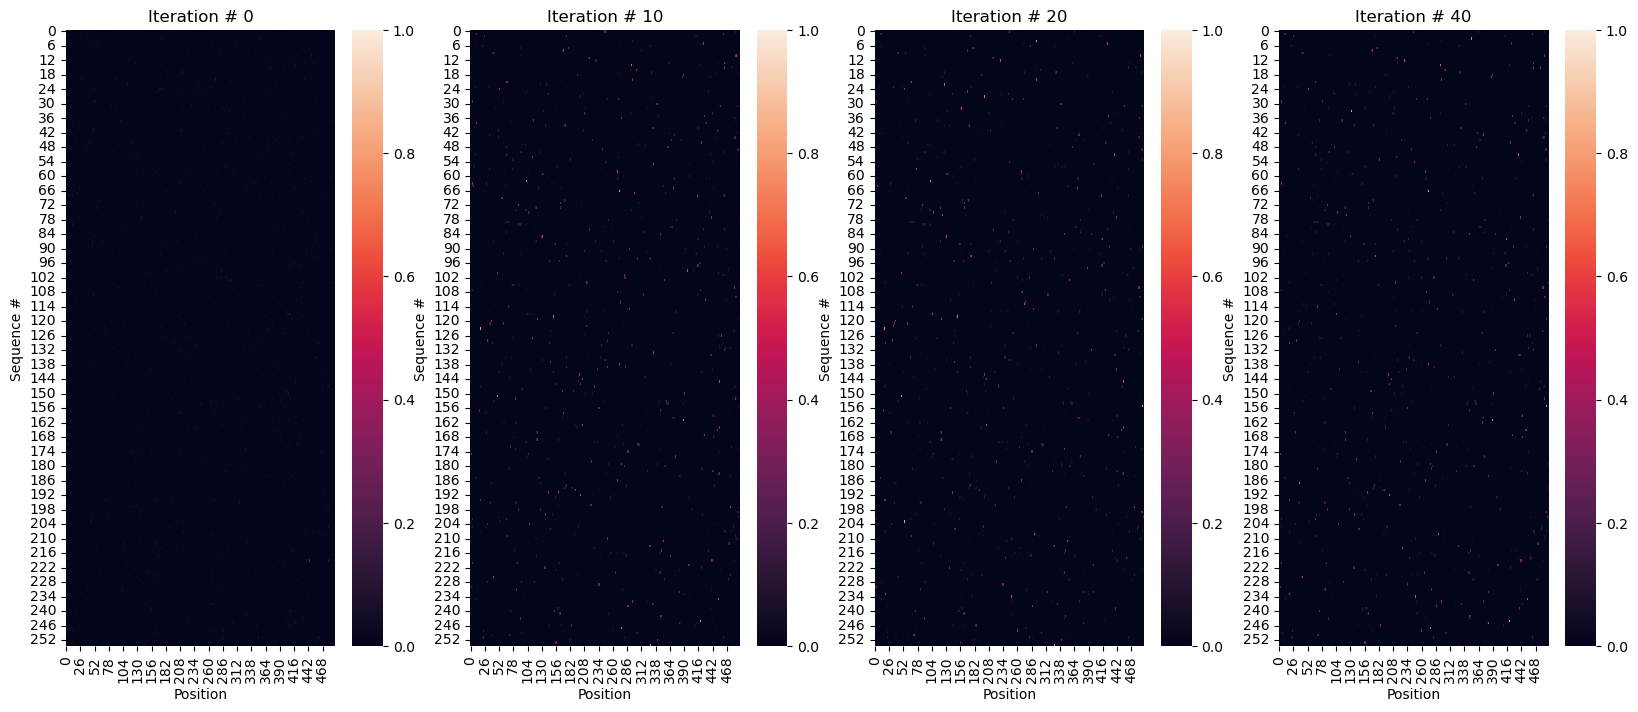

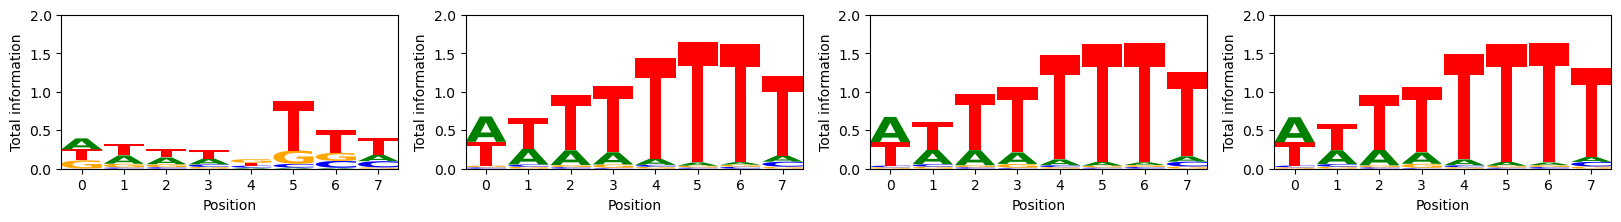

In [192]:
plot_results([0,10,20,40], est_motif, lls, positions_posteriors, motifs)